In [1]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

pd.options.display.max_columns = 99

%matplotlib inline
%load_ext lab_black

# for reading data
project_root_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
file_path = os.path.join(project_root_dir, "data")


def read_data(filename, file_path=file_path):
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path)

## Data Preprocessing

In [2]:
from sklearn.model_selection import train_test_split

grades = read_data("student-mat.csv")
X = grades.drop("G3", axis="columns")
y = grades["G3"]
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [3]:
print(X_train.shape)
print(X_test.shape)

(276, 32)
(119, 32)


In [4]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()
print(cat_cols[:5])
print("----------")
print(num_cols[:5])

['school', 'sex', 'address', 'famsize', 'Pstatus']
----------
['age', 'Medu', 'Fedu', 'traveltime', 'studytime']


In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [6]:
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N/A"),
    OneHotEncoder(handle_unknown="ignore"),
)
num_preprocessing = make_pipeline(SimpleImputer())
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing, cat_cols)]
)

In [7]:
# fit and transform the data
X_train_tr = preprocessing.fit_transform(X_train)
X_test_tr = preprocessing.transform(X_test)

In [8]:
# Get the list of categories generated by the one-hot-encoder
ohe_categories = preprocessing.named_transformers_["cat"]["onehotencoder"].categories_
# Create nice names for our one hot encoded features
new_ohe_features = [
    f"{col}__{val}" for col, vals in zip(cat_cols, ohe_categories) for val in vals
]
# Create a new list with all names of features
all_features = num_cols + new_ohe_features
# Create pandas dataframe
X_train_tr = pd.DataFrame(X_train_tr, columns=all_features)
X_test_tr = pd.DataFrame(X_test_tr, columns=all_features)

## Tree models

In [9]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree

tree = DecisionTreeRegressor(random_state=42, max_depth=3)
tree.fit(X_train_tr, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

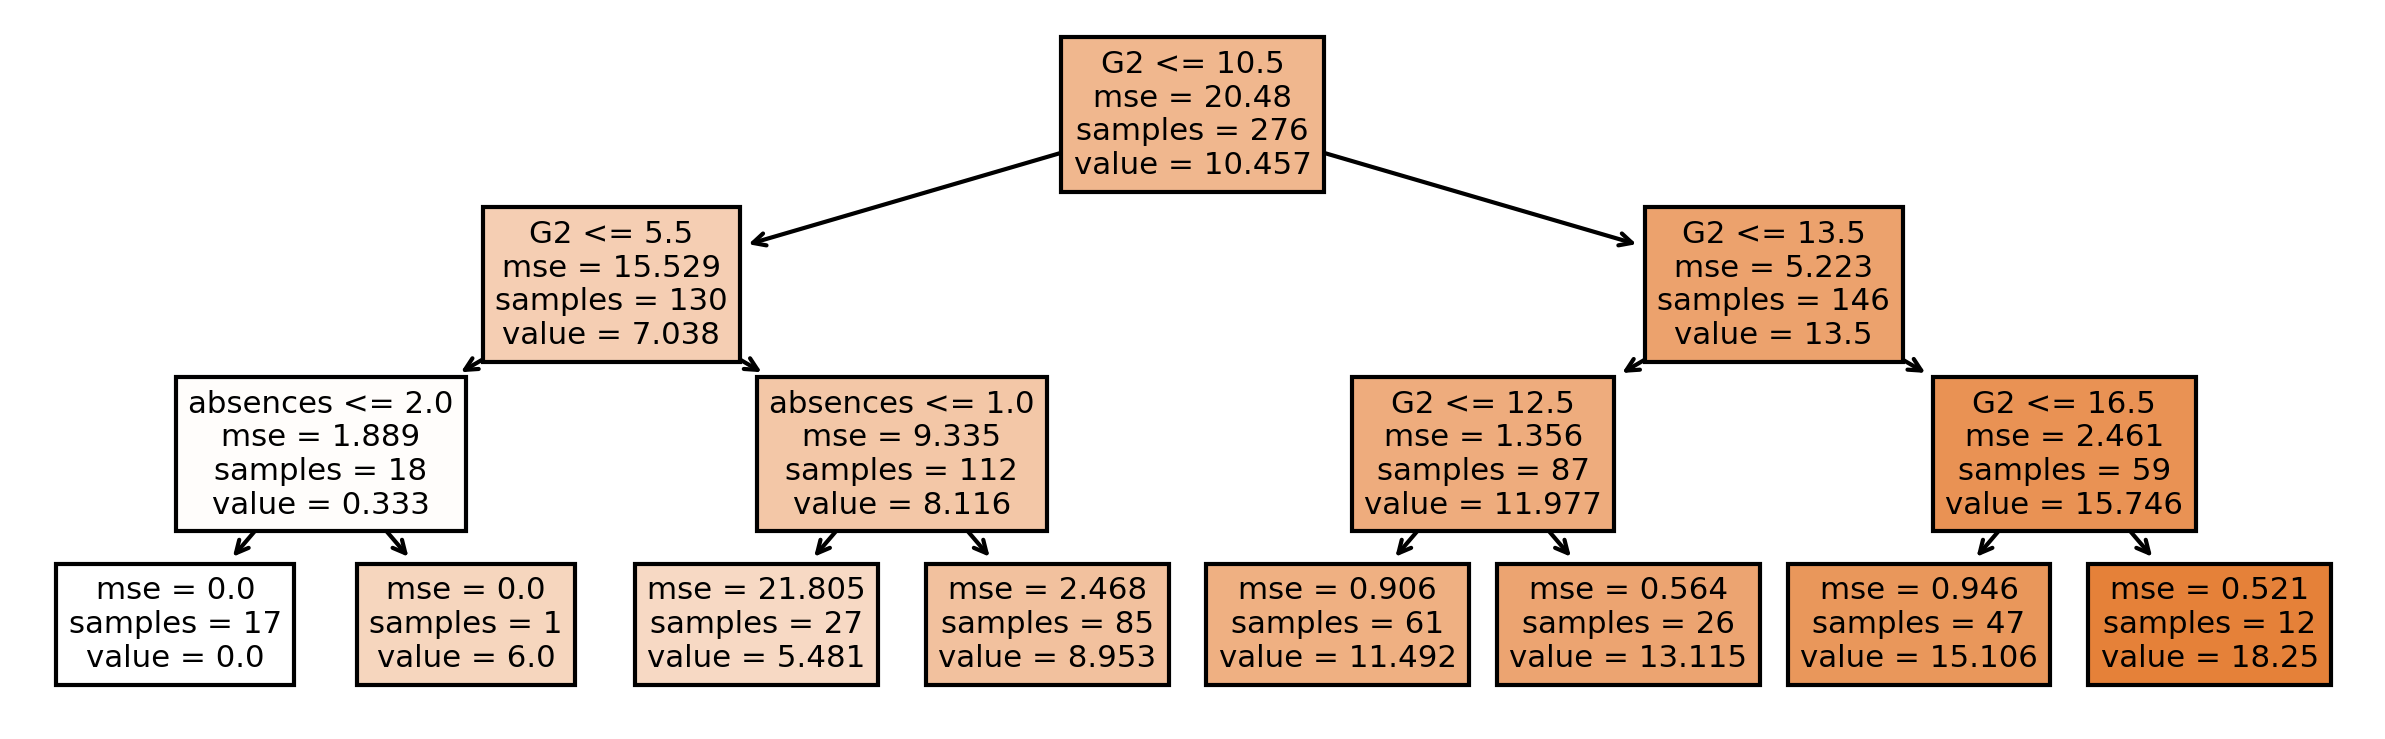

In [10]:
# plot the decision tree
plt.figure(figsize=(10, 3), dpi=300)
tree_dot = plot_tree(tree, feature_names=X_train_tr.columns, filled=True)
plt.savefig("../images/tree_plot.png")

In [11]:
from sklearn.model_selection import cross_val_score

tree = make_pipeline(StandardScaler(), DecisionTreeRegressor())
scores = cross_val_score(tree, X_train_tr, y_train, cv=10)
scores

array([0.55234435, 0.83287541, 0.86347013, 0.89401408, 0.93108352,
       0.69273782, 0.762939  , 0.6931327 , 0.68374817, 0.89970021])

In [12]:
scores.mean()

0.780604540838698

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
scores = cross_val_score(rf, X_train_tr, y_train, cv=10)
scores

array([0.86162218, 0.9124421 , 0.93603007, 0.86364296, 0.92442512,
       0.93698581, 0.91375494, 0.78152324, 0.83120232, 0.87331151])

In [14]:
scores.mean()

0.8834940235311753

So far, this the best score we get, so let's imporve this model further.

In [15]:
rf_scores = cross_val_score(
    rf, X_train_tr, y_train, cv=10, scoring="neg_mean_squared_error"
)
rf_rmse_scores = np.sqrt(-rf_scores)
rf_rmse_scores

array([1.85592103, 1.08572227, 1.18559057, 1.40562645, 1.32756087,
       1.07234723, 1.67814051, 1.93503852, 1.59070564, 1.6329546 ])

In [16]:
rf_rmse_scores.mean()

1.4769607686578152

In [17]:
rf_rmse_scores.std()

0.2933047136366598

## Hyperparameter optimization

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {"randomforestregressor__max_depth": range(1, 21)}
grid = GridSearchCV(rf, param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train_tr, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': range(1, 21)},
             return_train_score=True)

In [20]:
scores = pd.DataFrame(grid.cv_results_)
scores.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.203410,0.049700,0.012976,0.002280,1,{'randomforestregressor__max_depth': 1},0.579408,0.676832,0.579659,0.545325,0.567628,0.625782,0.545290,0.555194,0.429493,0.628544,0.573316,0.062618,20,0.579965,0.614392,0.594979,0.598745,0.610792,0.604729,0.595925,0.623060,0.607553,0.598342,0.602848,0.011407
1,0.250635,0.058930,0.016616,0.004747,2,{'randomforestregressor__max_depth': 2},0.859443,0.884136,0.813108,0.825265,0.861661,0.860588,0.832582,0.722968,0.697197,0.822458,0.817941,0.058091,19,0.841510,0.856282,0.846897,0.847810,0.854372,0.850748,0.852126,0.870317,0.862229,0.860590,0.854288,0.008005
2,0.306317,0.019319,0.018429,0.005533,3,{'randomforestregressor__max_depth': 3},0.896200,0.884818,0.863192,0.847270,0.881668,0.891615,0.883334,0.772552,0.775289,0.849198,0.854514,0.043302,18,0.890699,0.897770,0.891243,0.905130,0.899863,0.896004,0.898018,0.908205,0.904725,0.908432,0.900009,0.006125
3,0.239215,0.034950,0.012669,0.003045,4,{'randomforestregressor__max_depth': 4},0.864252,0.909757,0.919200,0.855269,0.911949,0.928642,0.901720,0.781829,0.815308,0.859252,0.874718,0.045950,17,0.948230,0.941660,0.938431,0.940914,0.939879,0.941217,0.940129,0.951742,0.943419,0.941175,0.942680,0.003930
4,0.285348,0.038419,0.013851,0.003565,5,{'randomforestregressor__max_depth': 5},0.861303,0.912942,0.929336,0.872163,0.918526,0.935236,0.912957,0.784560,0.825528,0.867475,0.882003,0.046631,15,0.968438,0.966423,0.962738,0.965643,0.963878,0.964539,0.963961,0.971227,0.966946,0.965558,0.965935,0.002367


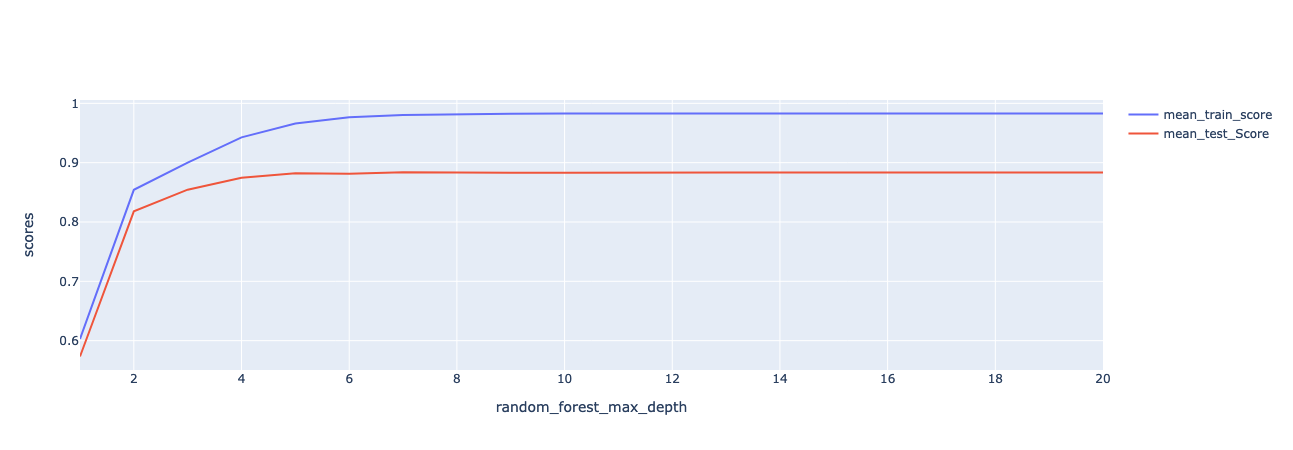

In [28]:
import plotly

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=scores["param_randomforestregressor__max_depth"],
        y=scores["mean_train_score"],
        name="mean_train_score",
    )
)
fig.add_trace(
    go.Scatter(
        x=scores["param_randomforestregressor__max_depth"],
        y=scores["mean_test_score"],
        name="mean_test_Score",
    )
)
fig.update_layout(
    xaxis=dict(title="random_forest_max_depth"), yaxis=dict(title="scores")
)
fig.show()

In [36]:
from utility import plot_validation_curves

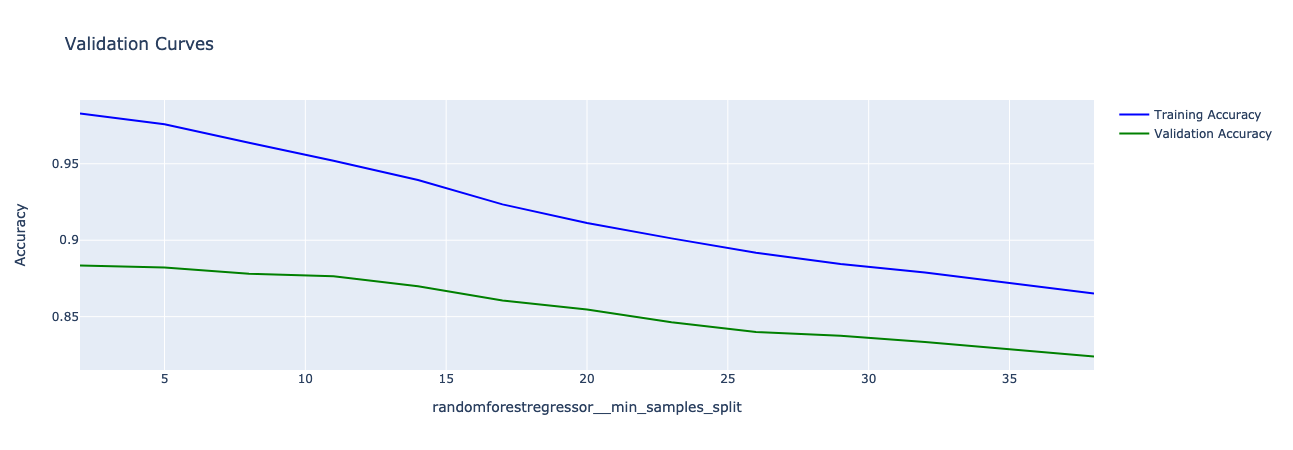

In [38]:
param_range = np.arange(2, 40, 3)

plot_validation_curves(
    rf, X_train_tr, y_train, "randomforestregressor__min_samples_split", param_range
)

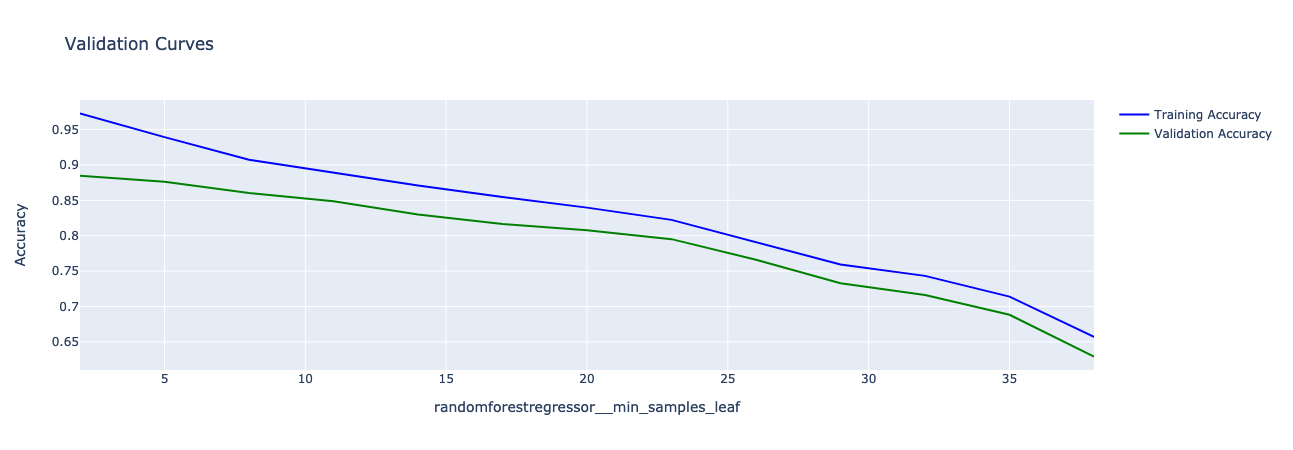

In [42]:
param_range = np.arange(2, 40, 3)

plot_validation_curves(
    rf, X_train_tr, y_train, "randomforestregressor__min_samples_leaf", param_range
)

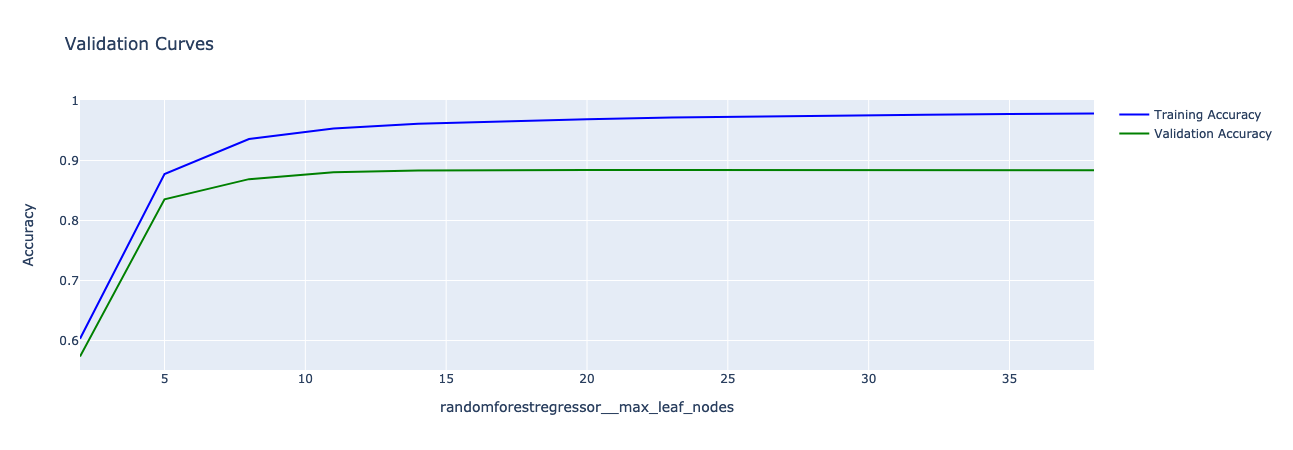

In [43]:
param_range = np.arange(2, 40, 3)

plot_validation_curves(
    rf, X_train_tr, y_train, "randomforestregressor__max_leaf_nodes", param_range
)

## Ranmdomized search

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [48]:
param_dist = {
    "randomforestregressor__max_depth": randint(low=1, high=8),
    "randomforestregressor__max_features": ["auto", "sqrt", "log2"],
    "randomforestregressor__min_samples_split": randint(low=5, high=20),
}

rf_reg = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1),
)

rnd_search = RandomizedSearchCV(
    rf_reg, param_distributions=param_dist, n_iter=20, cv=3, random_state=42
)
rnd_search.fit(X_train_tr, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_estimators=500,
                                                                    n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=20,
                   param_distributions={'randomforestregressor__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12481d460>,
                                        'randomforestregressor__max_features': ['auto',
                                                                                'sqrt',
                                                                                'log2'],
                                        'randomforestregressor__min_samples_split

In [49]:
rnd_search.best_score_

0.8547253144792339

In [51]:
rnd_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, min_samples_split=5,
                                       n_estimators=500, n_jobs=-1,
                                       random_state=42))])

In [52]:
scores = cross_val_score(rnd_search.best_estimator_, X_train_tr, y_train, cv=10)
scores

array([0.85851441, 0.91214583, 0.93719766, 0.87351705, 0.91313196,
       0.92689751, 0.9053287 , 0.7735217 , 0.80111803, 0.87824085])

In [53]:
scores.mean()

0.8779613695925464

In [54]:
rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
rf.fit(X_train_tr, y_train)
rf_pred = rf.predict(X_train_tr)

In [55]:
from sklearn.metrics import r2_score

r2_score(y_train, rf_pred)

0.9852203412123962

In [56]:
rnd_search.best_estimator_.fit(X_train_tr, y_train)
rf_rnd_pred = rnd_search.predict(X_train_tr)
r2_score(y_train, rf_rnd_pred)

0.9624276192687452

Based on the training and validation scores, it is observed that the score on the tunned model is little bit less than the model with default values but the tunned 
model is liitle bit better regularised than the default one, although the difference is not much in both the direction.So, let's stick with the tunned rf model

Let's also check the feature importances.

In [73]:
feat_labels = X_train_tr.columns.tolist()
importances = rnd_search.best_estimator_["randomforestregressor"].feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train_tr.shape[1]):
    print(
        "%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]])
    )

 1) G2                             0.813818
 2) absences                       0.106029
 3) reason__home                   0.017951
 4) age                            0.008804
 5) G1                             0.004609
 6) health                         0.004230
 7) schoolsup__no                  0.003467
 8) schoolsup__yes                 0.003330
 9) goout                          0.002756
10) famrel                         0.002751
11) Medu                           0.002452
12) studytime                      0.002382
13) Fjob__services                 0.001965
14) Walc                           0.001586
15) failures                       0.001581
16) reason__other                  0.001541
17) romantic__no                   0.001539
18) romantic__yes                  0.001457
19) guardian__mother               0.001290
20) Mjob__teacher                  0.001199
21) Fedu                           0.001191
22) freetime                       0.001150
23) Fjob__other                 

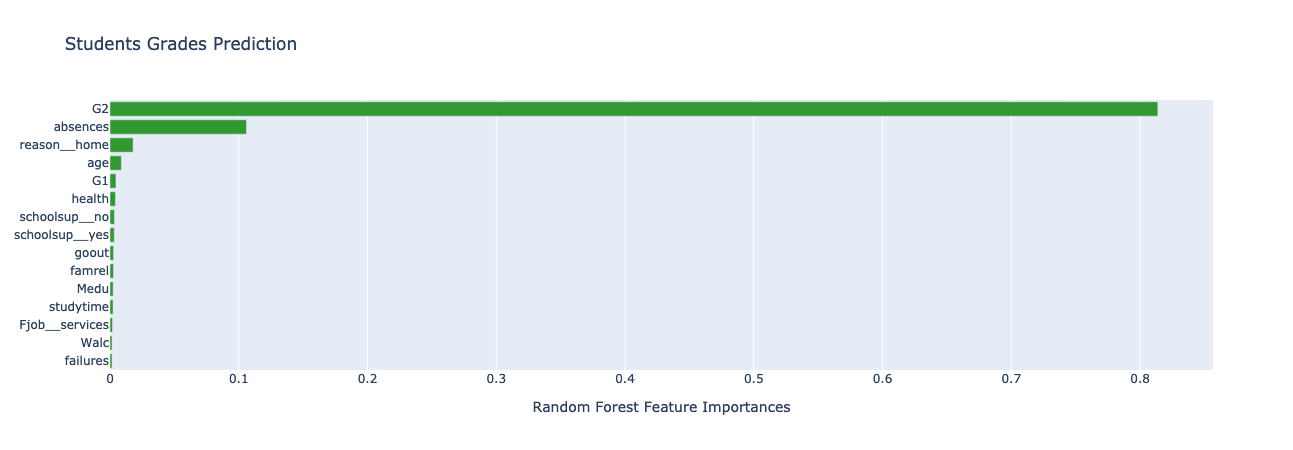

In [85]:
importances_list = []
feat_labels_list = []

for i in range(X_train.shape[1]):
    importances_list.append(importances[indices[i]])
    feat_labels_list.append(feat_labels[indices[i]])

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=importances_list[:15],
        y=feat_labels_list[:15],
        orientation="h",
        marker_color="#329932",
    )
)

fig.update_layout(
    title="Students Grades Prediction",
    yaxis=dict(autorange="reversed"),
    xaxis=dict(title="Random Forest Feature Importances"),
)
fig.show()

We can see that the students second period grades is the most important feature in predicting the final grades, followed by absences. Both these feature together
is nearly 92% important in predicting the students final scores and both of these features are related to students past performances. There are lots of other 
features about students, their lifestyle and about their parents but they are not too much important in predicting the grades. The results are consistent with
past research on this subject. 

As their are lots of irrelavent features, it is not very useful to use more advanced technique to improve the model as it won't improve it too much. 
so, let's check the score on the test set and end the study. 

In [79]:
# select only top 5 features
X_train_imp = X_train_tr[["G2", "absences", "reason__home", "age", "G1"]]
X_test_imp = X_test_tr[["G2", "absences", "reason__home", "age", "G1"]]
rnd_search.best_estimator_.fit(X_train_imp, y_train)
final_pred = rnd_search.best_estimator_.predict(X_test_imp)
r2_score = r2_score(y_test, final_pred)

In [80]:
r2_score

0.851686016444651

In [83]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, final_pred)
rmse = np.sqrt(mse)
rmse

1.8056155160048382